<a href="https://colab.research.google.com/github/qhruddl51/DeepLearning/blob/main/cat_BW_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 준비

In [33]:
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

In [34]:
from matplotlib.pyplot import imshow # 이미지 보여주는 함수
%matplotlib inline # matplotlib의 출력값이 쥬피터노트북에 보여지도록 함

UsageError: unrecognized arguments: # matplotlib의 출력값이 쥬피터노트북에 보여지도록 함


In [35]:
!ls

gdrive	sample_data


In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
# 모두 동일하게 64*428로 Resize, image에서 텐서로 변환
trans = transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root='./gdrive/MyDrive/origin_image', transform=trans)

In [38]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 76
    Root location: ./gdrive/MyDrive/origin_image
    StandardTransform
Transform: Compose(
               Resize(size=(64, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [39]:
# for num, value in enumerate(train_data):
#     print(num)
#     data, label = value 
#     print(data, label)

#     if num == 3 : 
#         break
    
#     # if(label == 0):
#     #     data.save('custom_data/train_data/gray/%d_%d.jpeg'%(num, label))
#     # else:
#     #     data.save('custom_data/train_data/red/%d_%d.jpeg'%(num, label))

# CNN model 적용

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [42]:
# 데이터 로더 생성
data_loader = DataLoader(dataset = train_data, batch_size = 9, shuffle = True, num_workers=2)

In [43]:
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120, 2)
        )
        pass # init


    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.layer3(out)
        return out # 최종적으로는 점수 값을 예측값으로 뱉어줄 것이다. 
        pass # forward

In [44]:
# testing
net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 64, 128)).to(device)
test_out = net(test_input)

In [45]:
# optimizer & loss_function
optimizer = optim.Adam(net.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().to(device)

In [46]:
total_batch = len(data_loader)
print(total_batch)

epochs = 10
for epoch in range(epochs) :
    avg_cost = 0.0

    for num, data in enumerate(data_loader) :
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = net(imgs)
        loss = loss_func(out, labels)
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch
        pass # iteration

    print(f'Epoch : {epoch+1} | cost : {avg_cost}')
    pass # epoch

print('Learning Finished!')

9
Epoch : 1 | cost : 0.6344156265258789
Epoch : 2 | cost : 0.592932403087616
Epoch : 3 | cost : 0.511462926864624
Epoch : 4 | cost : 0.4589909315109253
Epoch : 5 | cost : 0.44837120175361633
Epoch : 6 | cost : 0.39433079957962036
Epoch : 7 | cost : 0.32918015122413635
Epoch : 8 | cost : 0.2597030997276306
Epoch : 9 | cost : 0.22342759370803833
Epoch : 10 | cost : 0.15888802707195282
Learning Finished!


In [47]:
# model을 save
torch.save(net.state_dict(), "./gdrive/MyDrive/origin_image/model_cnn.pth")

In [48]:
# 저장된 모델을 불러와 사용
new_net = CNN().to(device)
new_net.load_state_dict(torch.load('./gdrive/MyDrive/origin_image/model_cnn.pth'))

<All keys matched successfully>

In [49]:
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.0933,  0.0011, -0.0193, -0.0234,  0.0910], grad_fn=<SelectBackward>)
tensor([-0.0933,  0.0011, -0.0193, -0.0234,  0.0910], grad_fn=<SelectBackward>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

In [50]:
# 학습시킨 모델을 테스트
trans=torchvision.transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])
test_data = torchvision.datasets.ImageFolder(root='./gdrive/MyDrive/test_image', transform=trans)

In [51]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [52]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        print(prediction)
        print(torch.argmax(prediction, 1))
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

tensor([[ 1.1583, -0.4421],
        [-1.5763,  1.6264]])
tensor([0, 1])
Accuracy: 1.0


In [53]:
import matplotlib.pyplot as plt

label :  tensor([0, 1])
tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961, 

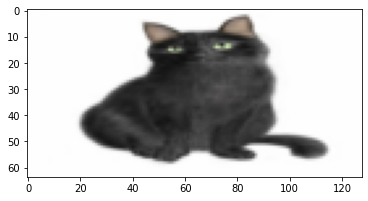

tensor([[[0.0863, 0.0863, 0.0902,  ..., 0.0824, 0.0902, 0.0863],
         [0.0902, 0.0902, 0.0902,  ..., 0.0863, 0.0902, 0.0863],
         [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0902],
         ...,
         [0.5412, 0.5647, 0.6275,  ..., 0.4902, 0.5176, 0.5098],
         [0.5137, 0.4745, 0.5176,  ..., 0.4706, 0.5255, 0.5529],
         [0.3922, 0.4118, 0.4078,  ..., 0.4667, 0.5059, 0.5569]],

        [[0.0627, 0.0627, 0.0667,  ..., 0.0471, 0.0588, 0.0627],
         [0.0667, 0.0627, 0.0667,  ..., 0.0510, 0.0627, 0.0627],
         [0.0706, 0.0706, 0.0706,  ..., 0.0510, 0.0627, 0.0667],
         ...,
         [0.5098, 0.5020, 0.5686,  ..., 0.4431, 0.4902, 0.4980],
         [0.4863, 0.4549, 0.5059,  ..., 0.3490, 0.4118, 0.4549],
         [0.2745, 0.3098, 0.3255,  ..., 0.3412, 0.3765, 0.4196]],

        [[0.0784, 0.0784, 0.0784,  ..., 0.0588, 0.0706, 0.0706],
         [0.0784, 0.0784, 0.0784,  ..., 0.0627, 0.0706, 0.0706],
         [0.0824, 0.0784, 0.0824,  ..., 0.0627, 0.0745, 0.

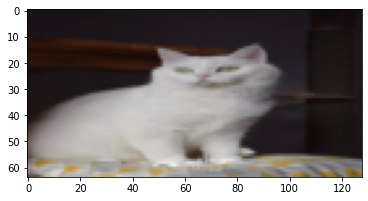

In [54]:
for datas, labels in test_set:  # 텐서 두 개 담은 리스트 
    print('label : ', labels)
    for i, d in enumerate(datas) :
        print(d)
        print(d.shape)
        d = d.permute(1, 2, 0)
        print(d.shape)
        plt.imshow(d)
        plt.show()